# Una demostración de agrupamiento K-Means en los datos de dígitos escritos a mano.

En este ejemplo comparamos las diversas estrategias de inicialización para K-means en términos de tiempo de ejecución y calidad de los resultados.

Dado que la verdad fundamental se conoce aquí, también aplicamos diferentes métricas de calidad de clúster para juzgar la adecuación de las etiquetas de clúster a la verdad fundamental.




In [ ]:
import numpy as np

from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

## Cargar el conjunto de datos.

Comenzaremos cargando el conjunto de datos de dígitos. Este conjunto de datos contiene dígitos escritos a mano del 0 al 9. En el contexto de la agrupación, se desearía agrupar imágenes de manera que los dígitos escritos a mano en la imagen sean los mismos.


In [1]:
import numpy as np

from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


## Definamos nuestro estándar de evaluación.

Primero estableceremos nuestro punto de referencia de evaluación. Durante este punto de referencia, tenemos la intención de comparar diferentes métodos de inicialización para KMeans.

In [2]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

## Ejecuta benchmark

Compararemos tres enfoques:

- Una inicialización utilizando k-means++. Este método es estocástico y realizaremos la inicialización 4 veces; 
- Una inicialización aleatoria. Este método también es estocástico y realizaremos la inicialización 4 veces; 
- Una inicialización basada en una proyección de PCA. De hecho, utilizaremos los componentes del PCA para inicializar KMeans. Este método es determinista y una única inicialización es suficiente.

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [6]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.116s	69545	0.598	0.645	0.621	0.469	0.617	0.158
random   	0.067s	69735	0.681	0.723	0.701	0.574	0.698	0.157
PCA-based	0.029s	69513	0.600	0.647	0.622	0.468	0.618	0.143
__________________________________________________________________________________


## Visualiza los resultados en datos reducidos por PCA.

PCA permite proyectar los datos del espacio original de 64 dimensiones a un espacio de menor dimensión. Posteriormente, podemos utilizar PCA para proyectar en un espacio de 2 dimensiones y graficar los datos y los clústeres en este nuevo espacio.


In [7]:
import matplotlib.pyplot as plt

In [10]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)
h = 0.02


## Trazar la frontera de decisión. Para eso, asignaremos un color a cada uno.

In [11]:
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

## Obtén etiquetas para cada punto en la malla. Utiliza el último modelo entrenado.




In [12]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

## Coloca el resultado en un gráfico de colores.


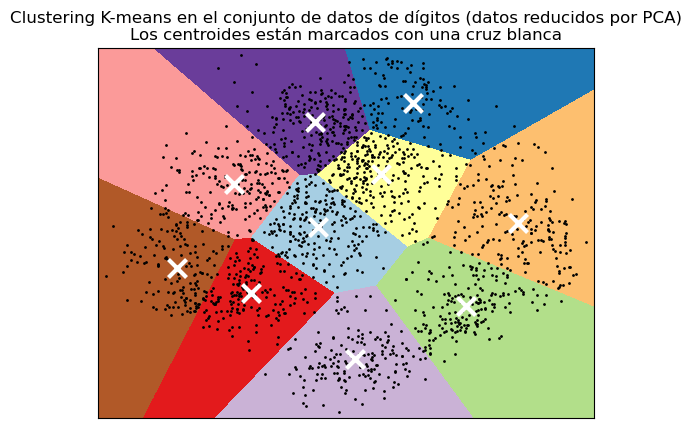

In [16]:
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "Clustering K-means en el conjunto de datos de dígitos (datos reducidos por PCA)\n"
    "Los centroides están marcados con una cruz blanca"


)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()